cuda:0
Files already downloaded and verified
Files already downloaded and verified
Testing hyperparameters: lr=0.001, batch_size=64, weight_decay=0.004
	Fold 1/5
		Epoch 1/1, Training Loss: 9.45101325419325e-05
Starting Validation Loop...
		Validation Loss: 0.11534217366875124
	Test Loss: 0.0018177378205582499
	Fold 2/5
		Epoch 1/1, Training Loss: 9.621014734850707e-05
Starting Validation Loop...
		Validation Loss: 0.11878923532810617
	Test Loss: 0.0018448512814939022
	Fold 3/5
		Epoch 1/1, Training Loss: 9.770945611112643e-05
Starting Validation Loop...
		Validation Loss: 0.12085056642359152
	Test Loss: 0.0018922527069225906
	Fold 4/5
		Epoch 1/1, Training Loss: 8.279560112535545e-05
Starting Validation Loop...
		Validation Loss: 0.1133955320552852
	Test Loss: 0.0017706794068217278
	Fold 5/5
		Epoch 1/1, Training Loss: 9.010833746952949e-05
Starting Validation Loop...
		Validation Loss: 0.12228764256173716
	Test Loss: 0.0018912533726543187
Average Test Loss: 0.0018433549176901578
Test

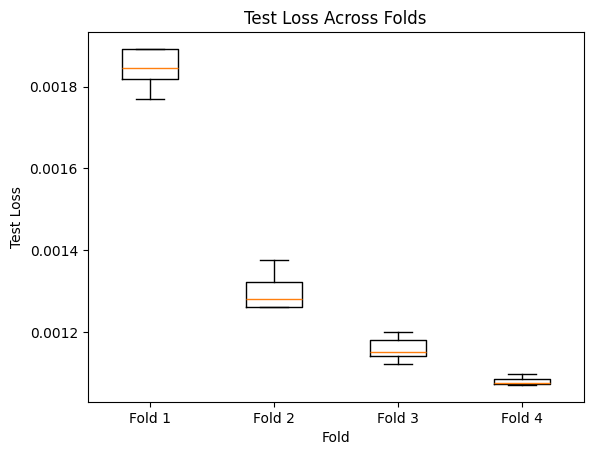

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import itertools
import sys


nc = 3
ndf = 96
ngf = 96
ngpu = 1
image_size = 96
beta1 = 0.5
num_epochs = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(device)

class Encoder(nn.Module):
    def __init__(self, ngpu, dim_z):
        super(Encoder, self).__init__()
        self.ngpu = ngpu
        nc = 3  # Number of input channels for the 96x96x3 image
        self.main = nn.Sequential(
            # input is (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf*8) x 6 x 6
            nn.Conv2d(ndf * 8, dim_z, 6, 1, 0, bias=False)
        )

    def forward(self, input):
        z = self.main(input)
        return z


class Decoder(nn.Module):
    def __init__(self, ngpu, dim_z):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z 64x1x1, going into a convolution
            nn.ConvTranspose2d( dim_z, ngf * 8, 6, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size: (ndf*8) x 6 x 6
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size: (ndf*4) x 12 x 12
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size: (ndf*2) x 24 x 24
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size: (ndf) x 48 x 48
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # input is (nc) x 96 x 96
        )

    def forward(self, input):
        return self.main(input)


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

def train_model(train_loader, val_loader, device, num_epochs, learning_rate, batch_size, weight_decay):
    encoder = Encoder(ngpu=1, dim_z=64).to(device)
    encoder.apply(weights_init)
    decoder = Decoder(ngpu=1, dim_z=64).to(device)
    decoder.apply(weights_init)
    criterion = nn.MSELoss()
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        encoder.train()
        epoch_correct = 0
        epoch_loss_val = 0

        for i, (data, labels) in enumerate(train_loader, 0):
            x = data.to(device)
            optimizer.zero_grad()
            z = encoder(x)
            x_bar = decoder(z)
            loss = criterion(x_bar, x)
            loss.backward()
            optimizer.step()
            
          
        epoch_loss_val += loss.item()
        
        avg_epoch_loss = epoch_loss_val / len(train_loader)

        print(f'\t\tEpoch {epoch + 1}/{num_epochs}, Training Loss: {avg_epoch_loss}')
        


    print('Starting Validation Loop...')
    encoder.eval()
    val_loss_value = 0

    with torch.no_grad():
        for data, labels in val_loader:
            x = data.to(device)
            z = encoder(x)
            x_hat = decoder(z)
            v_loss = criterion(x_hat, x)
            val_loss_value += v_loss.item()

    avg_val_loss = val_loss_value / len(val_loader)

    print(f"\t\tValidation Loss: {avg_val_loss}")

    return encoder, decoder, avg_val_loss

# Create a new transformation that resizes the images
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Define datasets
train_dataset = STL10(root='./data', split='train+unlabeled', transform=transform, download=True)
test_dataset = STL10(root='./data', split='test', transform=transform, download=True)

# Define hyperparameter grid
lr_values = [0.001, 0.0001]#, 0.01, 0.001, 0.0001]
bs_values = [64]#, 128, 256]
wd_values = [0.004, 0.0004]#, 0.04, 0.004, 0.0004]

# Perform hyperparameter tuning
best_hyperparameters = None
best_avg_loss = float('inf')







all_test_losses = []
best_fold = None
criterion = nn.MSELoss()
for lr, bs, wd in itertools.product(lr_values, bs_values, wd_values):
    print(f"Testing hyperparameters: lr={lr}, batch_size={bs}, weight_decay={wd}")



    # Initialize average loss for this set of hyperparameters
    avg_loss = 0.0

    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True)
    fold_test_losses = []  # Store test losses for each fold

    
    for fold, (train_index, val_index) in enumerate(kf.split(train_dataset)):
        print(f"\tFold {fold + 1}/5")

        train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

        train_loader = DataLoader(train_dataset, batch_size=bs, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=bs, sampler=val_sampler)
        test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

        # Train the model for this set of hyperparameters
        encoder, decoder, avg_val_loss = train_model(train_loader, val_loader, device, learning_rate=lr, batch_size=bs, weight_decay=wd, num_epochs=num_epochs)

        # Evaluate the model on the test set
        encoder.eval()
        test_loss_value = 0
        with torch.no_grad():
            for data, labels in test_loader:
                x = data.to(device)
                z = encoder(x)
                x_hat = decoder(z)
                t_loss = criterion(x_hat, x)
                test_loss_value += t_loss.item()
                
        test_loss = test_loss_value / len(test_dataset)

        print(f"\tTest Loss: {test_loss}")

        avg_loss += test_loss / 5  # Add test loss for this fold
        fold_test_losses.append(test_loss)
        

        # Update best hyperparameters if this set is better
        if avg_loss < best_avg_loss:
            best_avg_loss = avg_loss
            best_fold = fold
            best_hyperparameters = {'lr': lr, 'batch_size': bs, 'weight_decay': wd, 'fold': best_fold}
            best_model_state = encoder.main.state_dict()
    
    
    all_test_losses.append(fold_test_losses)

    print(f"Average Test Loss: {avg_loss}")
    
print(f"Best Hyperparameters: {best_hyperparameters}")
# Save the box plot
plt.boxplot(all_test_losses, labels=[f'Fold {i+1}' for i in range(len(all_test_losses))])
plt.xlabel('Fold')
plt.ylabel('Test Loss')
plt.title('Pre-Training 5-Fold CV - Test Loss Across Folds')
plt.savefig('AEPT5CV_box_plot.png')


learning_rate = best_hyperparameters['lr']
batch_size = best_hyperparameters['batch_size']
weight_decay = best_hyperparameters['weight_decay']
fold = best_hyperparameters['fold']

# Save the best model
if best_model_state is not None:
    PATH = '../models/aept_5cv_{}_{}_{}_F{}.pth'.format(learning_rate, batch_size, weight_decay, fold)
    torch.save(best_model_state, PATH)